In [1]:
import numpy as np 
from pathlib import Path
from src import utils, behavmatch, db
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import rcParams
default_font = 15
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange'] #rew #nrew #rew_test #nrew_test #GI
from IPython.display import clear_output

In [4]:
def dprime_cell(response, condition1, condition2, discrimination_region=(0,125), subpop=None):
    """
    Compute the d-prime for a single cell.
    """
    response = response[:,:,discrimination_region[0]:discrimination_region[1]].mean(2)
    r1 = response[:, condition1]
    r2 = response[:, condition2]
    if subpop is not None:
        r1 = r1[subpop]
        r2 = r2[subpop]
    # collect means and stds
    mu1 = r1.mean(1)
    mu2 = r2.mean(1)
    std1 = r1.std(1) + np.finfo(np.float64).tiny
    std2 = r2.std(1) + np.finfo(np.float64).tiny
    #compute the train dprime
    dp = 2 * ((mu1 - mu2) / (std1 + std2))
    return dp

def select_neurons(m1, area: str, celltype:str, dprime = None, dptsh=95):
    ia = utils.get_region_idx(m1.iarea, area)
    assert celltype in ['exc', 'inh'], "celltype must be either 'exc' or 'inh'"
    selected_type = np.logical_not(m1.isred[:,0]).astype(bool) if celltype == 'exc' else m1.isred[:,0].astype(bool)
    if dprime is None:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=dptsh) #tresh based on the area
    else:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dprime[ia*selected_type], tsh=dptsh)
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia * selected_type
    area_prefer_nr = prefer_nr * ia * selected_type
    return area_prefer_r, area_prefer_nr, selected_type, ia

def load_sessions(dbday, zscored:bool = True):
    mice = []
    if zscored:
        mdl_path = r"D:\mouseobj"
    else:
        mdl_path = r"D:\mouseobj\notz"
    for im, row in dbday.iterrows():
        name, date, blk = row['mname'], row["datexp"], row["blk"]
        m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=mdl_path)
        mice.append(m)
        clear_output(wait=True)
    print("sessions loaded")
    return mice

def compute_matched_cds(mice, probs):
    cbin = 3
    areas = ["V1", "medial", "lateral", "anterior"]
    c_types = ["exc", "inh"]
    corridor_length = 400 
    matched_cds = np.empty((len(mice), 4, len(areas), len(c_types), corridor_length)) # mice, ttype, areas, cell types, positions
    for im, row in mice.iterrows():
        name, date, blk = row['mname'], row["datexp"], row["blk"]
        m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
        protA = m.trial_dict["rewarded"][1::2]
        protB = m.trial_dict["non rewarded"][1::2]
        restA = m.trial_dict["rewarded test"]
        restB =  m.trial_dict["non rewarded test"]
        ## Dprime selection trials
        #if zscored == False:
        #    interp_spks = m.interp_spks - m.interp_spks.mean(1, keepdims=True)
        #else:
        #    interp_spks = m.interp_spks
        #correct, incorrect = utils.build_correct_dicts(m)
        #correctA_train = np.intersect1d(correct["rewarded"], m.trial_dict["rewarded"][::2])
        #correctB_train = np.intersect1d(correct["non rewarded"], m.trial_dict["non rewarded"][::2])
        dp = dprime_cell(m.interp_spks, m.trial_dict["rewarded"][::2], m.trial_dict["non rewarded"][::2], discrimination_region=(0,100))
        prot_matched_trials = behavmatch.match_trials_by_prob_bins(probs[im], cbin, protA, protB, bins=np.linspace(0, 1, 11), random_state=0)
        rest_matched_trials = behavmatch.match_trials_by_prob_bins(probs[im], cbin, restA, restB, bins=np.linspace(0, 1, 11), random_state=0)
        m_rew = np.concatenate(prot_matched_trials[:,0]).astype(int)
        m_nrew = np.concatenate(prot_matched_trials[:,1]).astype(int)
        m_rew_test = np.concatenate(rest_matched_trials[:,0]).astype(int)
        m_nrew_test = np.concatenate(rest_matched_trials[:,1]).astype(int)
        matched_dict = {"rewarded": m_rew, "non rewarded": m_nrew, "rewarded test": m_rew_test, "non rewarded test": m_nrew_test}
        for ia, area in enumerate(["V1", "medial", "lateral", "anterior"]):
            for ct, c_type in enumerate(["exc", "inh"]):
                a_prefer, b_prefer, _ , _ = select_neurons(m, area, c_type, dprime=dp)
                cd = m.interp_spks[a_prefer].mean(0) - m.interp_spks[b_prefer].mean(0)
                for it, trials in enumerate(matched_dict.values()):
                    matched_cds[im, it, ia, ct] = cd[trials,:].mean(0)
    return matched_cds

In [3]:
lday = db.get_sessions()
lday = lday.query("session == 'last training'").reset_index(drop=True)
lday

,mname,datexp,blk,session
0,VG11,2024_10_31,2,last training
1,VG11,2024_11_14,2,last training
2,VG14,2024_11_21,2,last training
3,VG15,2024_10_31,2,last training
4,VG21,2025_07_17,3,last training
5,VG24,2025_07_10,2,last training


In [5]:
zscored = True  # Set to False if you want to load non-zscored data
#mice = load_sessions(lday, zscored=zscored)
probs = np.load(Path(r"C:\Users\labadmin\Documents\category-neural\data\overall\last_training\overall_probs.npy"), allow_pickle=True)

In [ ]:
matched_cds = compute_matched_cds(lday, probs)
if zscored:
    np.save(Path(r"C:\Users\labadmin\Documents\category-neural\data\overall\last_training\cod_dirs_0_100_matched_updated.npy"), matched_cds)
else:
    np.save(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\last_training\cod_dirs_0_100_matched.npy"), matched_cds)

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'trial_dict', 'interp_spks', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'trial_dict', 'interp_spks', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

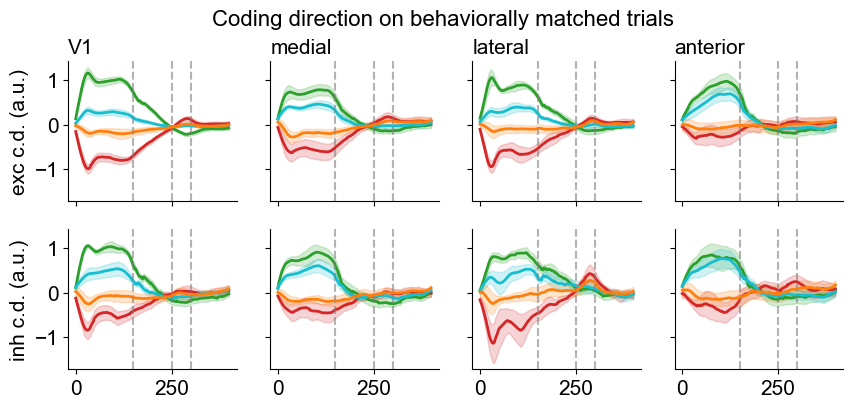

In [8]:
from scipy.stats import sem
areas = ["V1", "medial", "lateral", "anterior"]
c_types = ["exc", "inh"]
corridor_length = 400 
matched_mean = np.mean(matched_cds, axis=0)
matched_sem = sem(matched_cds, axis=0)
fig, ax = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
fig.suptitle(f"Coding direction on behaviorally matched trials", fontsize=fs_title, y=1.01)
for ttype in range(4):
    for a, area in enumerate(areas):
        ax[0, a].set_title(f"{area}", fontsize=default_font)
        for ct, c_type in enumerate(c_types):
            mean_response = matched_mean[ttype, a, ct]
            sem_response = matched_sem[ttype, a, ct]
            ax[ct, a].plot(mean_response, color=trial_type_palette[ttype], linewidth=2)
            ax[ct, a].fill_between(np.arange(400), mean_response - sem_response,
                                        mean_response + sem_response, color=trial_type_palette[ttype], alpha=0.2)
            ax[ct, a].axvline(x=150, color='gray', linestyle='--', alpha=0.2)
            ax[ct, a].axvline(x=250, color='gray', linestyle='--', alpha=0.2)
            ax[ct, a].axvline(x=300, color='gray', linestyle='--', alpha=0.2)
            if a==0:
                ax[ct, a].set_ylabel(f"{c_type} c.d. (a.u.)", fontsize=default_font)